# Solow Model with finite resources and climate externalities

Imports and set magics:

In [2]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
#XD FOR SMART UPLOAD
# local modules
import modelproject

# Model description



We consider a Solow-model that incorporates fossil fuels and climate externalities 

 The model structure is 

1 $$Y_t=D_tK^\alpha _t(A_tL_t)^{\beta}E^{\epsilon}_t,\text{   }\alpha, \beta, \varepsilon \geq0, \alpha+\beta+\varepsilon=1$$

2 $$ K_{t+1}=sY_t+(1-\delta) K_t, \text{  } 0<\delta<1 $$

3 $$L_{t+1}=(1+n)L_t, \text{   } n\geq 0$$

4 $$A_{t+1}=(1+g)A_t, \text{   } g\geq 0$$

5 $$ R_{t+1}=R_t-E_t$$

6 $$ E_t=s_ER_t, \text{   } 0<s_E<\delta $$

7 $$ D_t=\left(\frac{R_t}{R_0}\right)^{\phi},\text{   }\phi\geq 0$$






* $K_t$ is capital
* $L_t$ is labor (growing with a constant rate of $n$)
* $E_t$ is "Oil" (where the amount used in each period is a fraction of the remaining reserve)
* $R_t$ is the remaining reserve of oil, $R_0$ is the initial reserve 
* $A_t$ is technology (growing with a constant rate of $g$)
* $D_t$ is the damage function
* $Y_t$ is GDP





Using the above equations, the following transition curve can be found 

$$z_{t+1} =\left(\frac{1}{1-s_E}\right)^{\varepsilon+\phi}\left(\frac{1}{(1+n)(1+g)}\right)^\beta (s+(1-\delta)z_t)^{1-\alpha})z_t^\alpha$$

where $z_t$ is the capital/output ratio $z_t=\frac{K}{Y}$
 

## Specification of the damage function

In our model specification, the damage function directly affects the production Y. This means the direct interperetation of the damage function is that expending fossile fuels, R, destroys output. Other ways to model this could be that the damage function is applied to Capital or maybe add landmass to the model and have the damage function diminish the landmass. These alternative specifications can give the damage function a better interperetation. In the example of reducing landmass, the interperetation would be that expenditure of fossile fuels causes landmass to be reduced via global warming which melts ice that causes the sea level to rise. However, where we apply the damage function is irrelevant, as they are mathematically equivalent if you scale $\phi$

Say for example, the damage function affected Capital instead of directly diminishing output, our model would look like:

$$Y_t=(K_tD_t)^\alpha(A_tL_t)^{\beta}E^{\epsilon}_t,\text{   }\alpha, \beta, \varepsilon \geq0, \alpha+\beta+\varepsilon=1$$

$\leftrightarrow$

$$Y_t= D_t^\alpha K_t^\alpha(A_tL_t)^{\beta}E^{\epsilon}_t,\text{   }\alpha, \beta, \varepsilon \geq0, \alpha+\beta+\varepsilon=1$$

Which means, that if we scale $\phi$ by $\frac{1}{\alpha}$, these would be completly equivalent. Which is why we don't think it's a problem to have $D_t$ directly affect $Y_t$, despite the implication that usage of fossile fuels directly destroys output. The damage function can essentially be seen as a part of the TFP.

## Solving the model - steady state

* 1 Find the transition equation, which describes the evolution of the economy given the initial values. In this case the transition equation have already been found (equation 8). 
 
* 2 Specify the parameters of the model  

* 3 Find the steady state, that is the point to which the economy converges. In this case steady state is described in terms of the capital-output ratio, since it does not converge in capital per worker. 


In [3]:
# First we consider the Solow model without climate externalities, that is we reduce the model to a Solow model extended with oil only, which is equal to setting phi to zero
# Parameters: 

epsilon = 0.1
beta = 0.6
alpha = 0.3
phi = 0 
delta =0.05
n = 0.01
g = 0.02
s =0.20
se = 0.005

# all parameters are given reasonable values based on those given in chapter 7 in Introducing Advanced Macroeconomics by Sørensen and Jacobsen  

Convergence requires that 
$$z_{t+1}=z_t \Leftrightarrow z_{t+1}-z_t=0$$

In [4]:
# We define the object function using the above condition 
obj_zss = lambda z: z- (1/(1-se))**(epsilon+phi)*((1/((1+n)*(1+g)))**beta)*((s+(1-delta)*z)**(1-alpha))*z**alpha


In [5]:
# Now we optimize using the "brentq" method 
Interval = [0.1,100]# An interval in which we expect to find the steady state, defined in a way so that we aviod the trivial steady state

result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq") # Calling an optimize from scipy 
print(f'The steady state for z is: z* = {result.root:.3f}') # Printing the steady state value

The steady state for z is: z* = 2.663


In [6]:
# Now we introduce climate change in the form of the damage function, but allow phi to take various values 
phis=[0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2] # List of different values that phi can take 

SS_list =[] # List used to save the steady state values
for phi in phis: # Obtaining various SS values for z by changing phi 
    result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq")
    SS_list.append(result.root) 

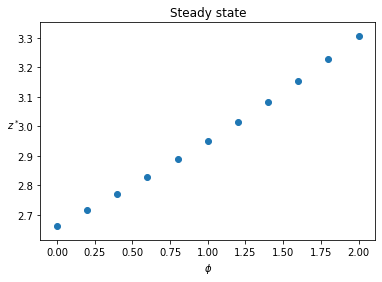

In [7]:
#Plotting relationship between steady state and phi
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cs = plt.scatter(phis,SS_list)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$z^*$').set_rotation(0)
ax.set_title("Steady state");

In the above plot it can be seen that $z^*$ is increasing in $\phi$. This is a due to the fact, that for a given capital stock less output will be produced when $\phi$ increases due to a larger climate externality effect 

## Simulation

We create functions of the model equations we introduced earlier:

In [8]:
from modelproject import Y_t, D_t, E_t, A_t1, K_t1, L_t1, R_t1

Then we create a function to simulate the model

In [9]:
def simulate(K0,A0,L0,R0,periods,a=0.3,b=0.6,e=0.1,g=0.02,n=0.01,s=0.2,phi=1,sE=0.005,d=0.05):
    """Simulates the Solowmodel for given starting values of capital, labour, technology and fossil fuels aswell as given model parameters""" 

# First we generate lists to store the output for each endogenus variabel and add/calculate the period 0 values:

    listA = [A0]
    listK = [K0]
    listL = [L0]
    listR = [R0]
    listD = [1]   # The damage function will always be 1 in period 0, since R_t=R_0 -> (R_t/R_0)^phi=1
    listE = [E_t(sE = sE, R = R0)]
    listY = [Y_t(listD[-1], K0, A0, L0, listE[-1], a = a, b = b, e = e)]
    listt = [0] # We always start in period t=0, so the first element in t is 0

    # Now we simulate for the amount of periods specified:
    i = 1 # Where i indicates the period, so we start by simulating periode t=0+1=1
    # The following calculations are done in order of causality, so we can call the last element in the needed variable list, therefore Y has to be done last, so the last element in K, A, L and so on has already been updated for the current period.
    while i <= periods:
        listA.append(A_t1(listA[-1],g = g))
        listK.append(K_t1(Y = listY[-1], K = listK[-1], s = s, d = d))
        listL.append(L_t1(listL[-1], n = n))
        listR.append(R_t1(listR[-1], E = listE[-1]))
        listE.append(E_t(R = listR[-1], sE = sE))
        listD.append(D_t(R = listR[-1], R_0 = R0, phi = phi))
        listY.append(Y_t(D = listD[-1],K = listK[-1],A = listA[-1],L = listL[-1],E = listE[-1], a = a, b = b, e = e))
        listt.append(i)
        i+=1
    
# We return the lists for Y, L, K, t and D as they are the variables we are interested in analyzing.
    return listY, listL, listK, listt, listD, listR

In [10]:
# We define a list of phi values we want to analyze. 
# We chose 0, 0.5, 1 and 2 instead of 0, 0.5, 1 and 1.5, because it make a plot later on symmetrical.
philist = [0, 0.5, 1, 2]

In [11]:
# Then we create some list containing 4 lists of the Y, K etc. values for each phi value in philist. The [0] and [2] are because the simulate-function returns 6 lists with Y being index 0 and K beign index 2 etc. 
smalltlist = simulate(1,1,1,1,200)[3]
smalllist = simulate(1,1,1,1,200)[1]
smallklist = np.array([simulate(1,1,1,1, 200, phi = phi)[2] for phi in philist])
smallylist = np.array([simulate(1,1,1,1, 200, phi = phi)[0] for phi in philist])
smalllowercaseylist = np.divide(smallylist,smalllist)
smalllowercaseklist = np.divide(smallklist,smalllist)
smallzlist = np.divide(smalllowercaseklist,smalllowercaseylist)

In [12]:
# We then create a figure showing 2 plots, one of z and one of y both against time.
lilyfig = plt.figure(figsize = [15, 8])
ox1 = lilyfig.add_subplot(2,1,1)

plt.plot(smalltlist,smalllowercaseylist[0], label = "$\phi$ = 0")
plt.plot(smalltlist,smalllowercaseylist[1], label = "$\phi$ = 0.5")
plt.plot(smalltlist,smalllowercaseylist[2], label = "$\phi$ = 1")
plt.plot(smalltlist,smalllowercaseylist[3], label = "$\phi$ = 2")
plt.legend()

h = plt.ylabel("$y_t$")
h.set_rotation(0)
plt.xlabel("t")
ox1.set_title("Income per worker")

ox2 = lilyfig.add_subplot(2,1,2)
plt.plot(smalltlist,smallzlist[0], label = "$\phi$ = 0")
plt.plot(smalltlist,smallzlist[1], label = "$\phi$ = 0.5")
plt.plot(smalltlist,smallzlist[2], label = "$\phi$ = 1")
plt.plot(smalltlist,smallzlist[3], label = "$\phi$ = 2")
plt.legend()


# We hide the axis labels and tick of the upper plot, as they share the same axis.
ox1.axes.get_xaxis().set_visible(False)

h = plt.ylabel("$z_t$")
h.set_rotation(0)
plt.xlabel("t")
ox2.set_title("Capital/Income ratio")
plt.close(lilyfig)

Analysis of figure goes here :)

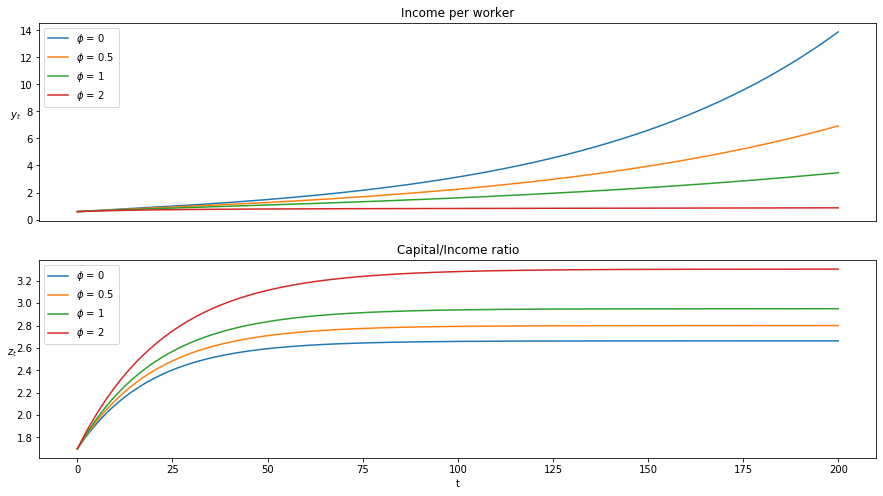

In [13]:
lilyfig

## What is a realistic value of $\phi$?

We now simulate the damage function and the remaining amount of fossile fuels over 2000 periods. We use this many periods because the amount of fossile fuels, R, declines rather slowly. 

In [34]:
dlist = np.array([simulate(1,1,1,1, 2000, phi = phi)[4] for phi in philist])
rlist = simulate(1,1,1,1,2000)[5]
ylist = np.array([simulate(1,1,1,1, 2000, phi = phi)[0] for phi in philist])
llist= np.array([simulate(1,1,1,1, 2000, phi = phi)[1] for phi in philist])
lowercaseylist = np.divide(ylist,llist)

In [15]:
# Then we plot the damage function against the remaining amount of fossile fuels. The figure doesn't show because we closed the figure display, this is to give it more space.
# Create the figure object
damagefig = plt.figure(figsize = [8, 8])
ax = fig.add_subplot(1,1,1)
# Then we add the dataseries
plt.plot(rlist, dlist[0], label = "$\phi$ = 0")
plt.plot(rlist, dlist[1], label = "$\phi$ = 0.5")
plt.plot(rlist, dlist[2], label = "$\phi$ = 1")
plt.plot(rlist, dlist[3], label = "$\phi$ = 2")
plt.legend()
h = plt.ylabel("$D_t$")
h.set_rotation(0)
plt.xlabel("$R_t$")
# We define the lower limit of the y-axis
plt.ylim(bottom = 0)
plt.close(damagefig)

The figure plots the damage function against the remaining amount of fossile fuels, for different values of $\phi$. Unsurprisingly, when $\phi$ = 0, the damage function remains at 1 the entire time, because $\phi$ = 0 $\rightarrow$ $D_t$ = 1 $\forall$ $R_t$.

When $\phi$ = 1 the damage function becomes linear and since we chose $R_0$ = 1 the slope is exactly -1, although the axis is inverted. In any case, the implication of having $\phi$ = 1 is that climate change linearly damages production (the economy). This isn't exactly in line with reality, an argument for this is, that a global increase in temperature of 0.1 degrees celcius will barely have any effect on the world. Whereas a global increase in temperature of 1 degrees will impact economies in many ways, positive and negative, see https://link.springer.com/article/10.1023/A:1014500930521 for some estimates of a 1 C degree increase. Although these estimates are positive when using a simple sum and negative when using global average values.

Either way we expect the damage of climate changes to grow exponentially. Therefore we reject $\phi$ > 1 because it gives a concave damage function meaning small amounts of fossile fuel usage lead to great losses in output. From the red curve in the figure below you can see that with $\phi$ = 2, the damagefunction falls very quickly, but then becomse flatter.

Having $\phi$ < 1 means that the damages are convex, so that small expenditures of fossile fuels only lead to minor losses due to climate changes. But as more fossile fuels are used, the damage grows for each unit of fuel used. This is more in line with our expectations and therefore we think 0 < $\phi$ < 1 suits the model best.

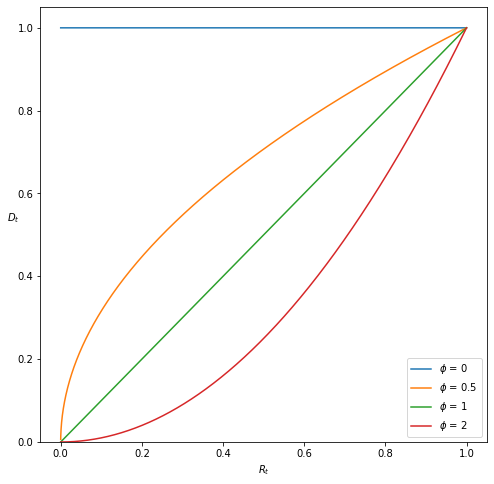

In [16]:
# Now we display the figure. Now there's also some space for the analysis text above :).
damagefig

# Growth Rates 

We now consider the growth rates towards steady state and the growth rates in steady state. This is done by: 

* 1 Solving the model numerically as we did in the beginning, but only using the values for $\phi$ used in the simulation above

* 2 Find the period in which the economy has converged to steady state. We define that period as the period, in which the difference between $z_t$ and $z^*$ is below 0.5%

* 3 Then for each $\phi$ we calculate the average growth rate from period t=0 to that period in which the economy has converged, and the growth rate in steady state 


In [21]:
SS_list_new=[] # List to store steady states for various phi
Period_list=[] # List to store periods in which the economy has converged for various phi 

for phi in philist: # Obtaining various SS values for z by changing phi 
    result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq")
    SS_list_new.append(result.root) 

# Now for each phi we loop through the smallzlist to find steady state 
for i in range(0,4,1): # Loop over steady states  
    for j in range(0,200,1): # Loop through period 
        if (SS_list_new[i]-smallzlist[i][j])/SS_list_new[i]<0.005: 
            period = j
            Period_list.append(period)
            break
    print(f'For \u03C6 = {philist[i]} the economy is in steady in period t = {Period_list[i]}')




For φ = 0 the economy is in steady in period t = 82
For φ = 0.5 the economy is in steady in period t = 88
For φ = 1 the economy is in steady in period t = 94
For φ = 2 the economy is in steady in period t = 108


In [44]:
# Growth rates towards Steady State

for i in range(0,4,1): # Looping over the various steady states 
    growth_factor = smalllowercaseylist[i][Period_list[i]]/smalllowercaseylist[0] # Calculating the growth factor over the entire period 
    avg_growth = (growth_factor**(1/Period_list[i])-1)*100 # Using the growth factor to calcualte the average growth 
    print(f'The average growth rate towards steady state for \u03c6 = {philist[i]} is: {avg_growth[i]:.3f}') # Printing 





The average growth rate towards steady state for φ = 0 is: 1.731
The average growth rate towards steady state for φ = 0.5 is: 1.345
The average growth rate towards steady state for φ = 1 is: 0.965
The average growth rate towards steady state for φ = 2 is: 0.241


In [45]:
# Growth in steady state 

for i in range(0,4,1): # Looping over the various steady states 
    growth_factor = lowercaseylist[i][-1]/(lowercaseylist[i][Period_list[i]]) # Calculating the growth factor from first SS period to period 2000
    avg_growth = (growth_factor**(1/(2000-Period_list[i]))-1)*100 # Using the growth factor to calcualte the average growth from first SS to period 2000, to get the approximative steady state growth rate 
    print(f'The average growth rate towards steady state for \u03c6 = {philist[i]} is: {avg_growth}') # Printing 


The average growth rate towards steady state for φ = 0 is: 1.494783340819783
The average growth rate towards steady state for φ = 0.5 is: 1.1320409191938774
The average growth rate towards steady state for φ = 1 is: 0.7705974567818297
The average growth rate towards steady state for φ = 2 is: 0.051580043660970354




# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.